# FlashX/igraph DWI Big-graph Comparison

In this notebook, we will use a miniature example to demonstrate the usage of FlashX for large network analysis. 

## Data

We will use the [BNU1](http://fcon_1000.projects.nitrc.org/indi/CoRR/html/bnu_1.html) dataset collected as part of the CoRR initiative. 


## Processing

The data are processed using the [ndmg](https://github.com/neurodata/ndmg) pipeline, a pipeline that takes raw Multi-Modal-Magnetic Resonance Images (M3R) and translates them into structural connectomes. Diffusion imaging essentially looks at the paths that water can take through the brain by varying the angle and intensity at which the scanner collects data (referred to as the diffusion angle bvector and diffusion intensity bvalue respectively). Using this imaging technique, big structural connectomes are estimated as follows:

1) Registration: during the registration step, we reduce spatial noise present between scans. Spatial noise includes things such as head-motion, where a subject moves their head in between sessions, introducing small deviations in terms of head position that must be accounted for between each different diffusion angle. Also, the difference in subject head shape must be accounted for. We linearly transform the head shapes of the individual subjects to anatomical templates, which are essentially the average brain of the population, to allow for spatial comparisons downstream of subjects.

2) Tensor estimation: during the tensor estimation step, we estimate the the gradients which the water molecules are able to travel through the brain.

3) Tractography: during the tractography step, we estimate the physical paths water molecules take through the brain, forming what are referred to as "fiber streamlines", which essentially are just the collection of voxels in the brain that an individual fiber are incident to. 

4) Graph estimation: using the fiber maps, we trace each individual fiber streamline for incident voxels in the brain. We take all possible combinations of voxels the fiber is incident to (since this means that there exists a path, the fiber itself, that molecules could take from one voxel in the fiber to the next) and define these voxels as structurally connected by incrementing the edge weight between these two voxels. Our graph vertices are defined as the set of all voxels that are adjacent to at least one fiber.

more details can be found in our [in-progress manuscript](https://github.com/neurodata/ndmg-paper/blob/master/ndmg.pdf). 

## Analysis

Using these graphs we have estimated, it is of particular interest for modern neuroscientists to perform graph-based statistical analyses. Neuroscientists believe that these graphs, or connectomes, may hold properties that differ by biological phenotypes, such as levels of intelligence, neurological illnesses, and many other neurologically significant properties. Unfortunately, these big-graphs we have described are incredibly large; they are on the order of about 1 million voxels in a typical brain at 1mm resolution. Up until this point, neuroscientists combatted this problem by reducing the size of the graphs, by essentially combining voxels that are spatially local using parcellation atlases, which essentially tell scientists what region of the brain a given voxel is part of. However, by leveraging FlashX, we show that this problem is no longer a barrier for large brain analytics. 

We begin with a simple experiment. To run the following data, please replace nthreads with the number of threads your computer will support. If this argument is left at 1, each subject will run serially, which will have the disadvantage of being relatively slow:

```
nthreads = 20  # replace with your number of threads

system(paste('ndmg_bids /data/BNU1 /outputs/BNU1 participant dwi --bg --nthreads', toString(nthreads)))

```

Next, let's take a look at some of the quality control figures produced. As we mentioned above, the purpose of diffusion-weighted MRI processing is to identify the tracts through the brain that water molecules can take, which form the structural connections of our brain. Let's take a look at the fibers estimated by NDMG. Unfortunately, we can only browse the quality control of the fibers themselves at 1mm resolution (our data is 4mm for speed) since the fibers are incredibly fine. However, below we can take a look at the tensors that the water molecules take through the brain:

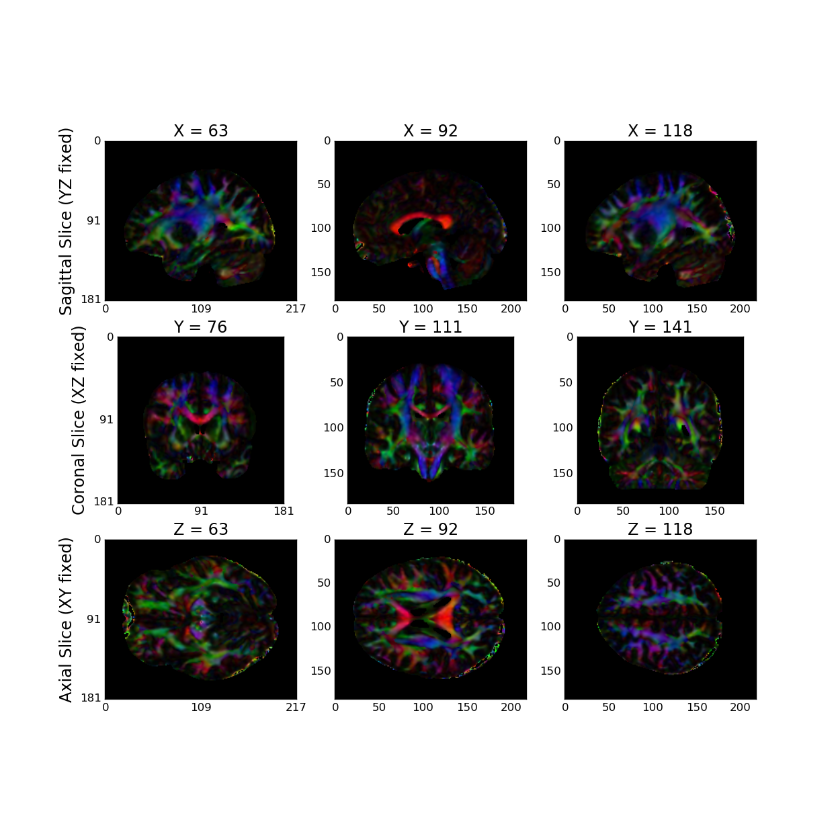

In [1]:
library(png)
img <- readPNG('/mnt/nfs2/MR/dwi/BNU1/qa/tensors/sub-0025864_ses-1_dwi_tensors_fa_rgb.png')
grid::grid.raster(img)

Below, we will use the big graphs estimated by the ndmg pipeline on our downsampled data to estimate several notable graph statistics: the degree per vertex, the number of triangles a vertex is part of, the locality statistic with k=1, and the eigenvalues of the adjacency representation of the graph. We will estimate first with FlashR, the R bindings for FlashX, and second with igraph, another common graph analysis package. It is important to note that this data is very small, and is under 10,000 vertices for speed. FlashR is designed to vastly outperform (if igraph can even run at all) on very large (100,000 or more vertices) graphs, so we do not anticipate obtaining an advantage in this setting. However, this notebook is useful to introduce the FlashR API, and demonstrate that it produces equivalent results to other graph packages:

In [15]:
require(FlashGraphR)
fg.set.conf("/mnt/nfs2/zhengda/FlashX-stable/flash-graph/conf/run_test.txt")
require(igraph)

# the directory that biggraphs would be placed
inpath <- '/mnt/nfs2/MR/dwi/BNU1/biggraphs/'
elist_names <- list.files(inpath, pattern="\\.edgelist", full.names=TRUE)

# iterate through elist names to load for fx and igraph
fx_graphs <- sapply(elist_names, function(x) {
    g <- fg.load.graph(x, directed=FALSE)
    degs <- fg.degree(g)
    degnz <- as.vector(degs != 0)  # non-isolated vertices
    return(fg.fetch.subgraph(g, vertices=which(degnz)))
    }, simplify = FALSE)

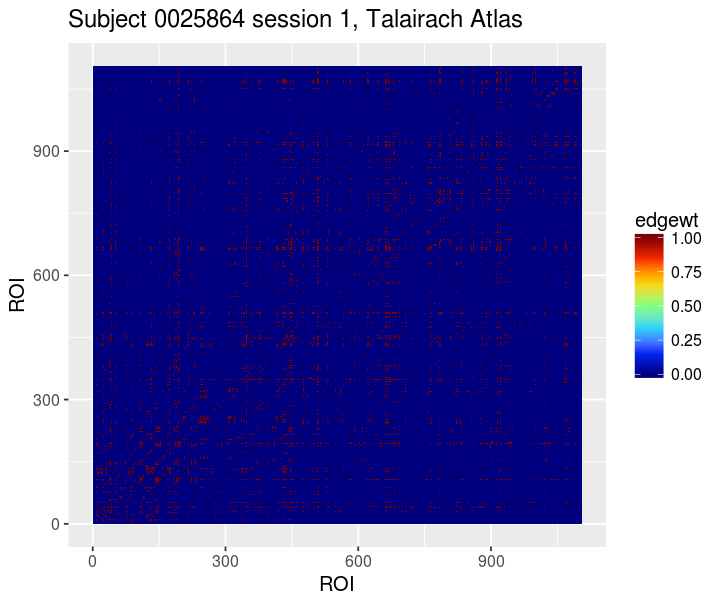

In [16]:
options(repr.plot.height=5, repr.plot.width=6)

require(Discriminability)
require(stringr)
require(R.utils)
source('./analyze_performance.R')
source('./compare_distribution.R')

tal_graph = read.graph('/mnt/nfs2/MR/dwi/sub-0025864_ses-1_dwi_Talairach.graphml', format='graphml')
plot_square(as.matrix(as_adj(tal_graph)), legend = 'edgewt', title = 'Subject 0025864 session 1, Talairach Atlas')

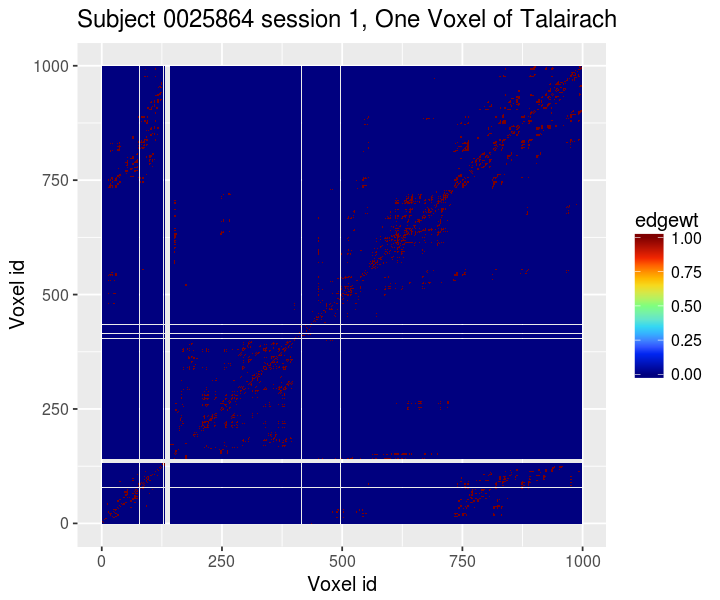

In [17]:
options(repr.plot.height=5, repr.plot.width=6)
require(FlashR)
one_pix_gra <- fg.fetch.subgraph(fx_graphs[[1]], vertices = 1:1000)
gfile <- 'smallgraph.edgelist'
one_pix_adj <- fg.print.graph(one_pix_gra, gfile)
one_pix_igraph <- read_graph(gfile, format='ncol', directed=FALSE)
plot_square(as.matrix(as_adj(one_pix_igraph)), legend = 'edgewt', xlabel = 'Voxel id', ylabel='Voxel id',title = 'Subject 0025864 session 1, One Voxel of Talairach')

For each subject, we compute our graph statistics first using FlashX. These have been precomputed due to runtime, so we plot results below:

In [1]:
fx.tris.vals <- readRDS('fxtrisvals.rds')
fx.locs.vals <- readRDS('fxlocsvals.rds')
fx.degs.vals <- readRDS('fxdegsvals.rds')
fx.eigs.vals <- readRDS('fxeigsvals.rds')

fx.tris.time <- readRDS('fxtristimes.rds')
fx.locs.time <- readRDS('fxlocstime.rds')
fx.degs.time <- readRDS('fxdegstime.rds')
fx.eigs.time <- readRDS('fxeigstime.rds')

fx.tris.mem <- readRDS('fxtrismem.rds')
fx.locs.mem <- readRDS('fxlocsmem.rds')
fx.degs.mem <- readRDS('fxdegsmem.rds')
fx.eigs.mem <- readRDS('fxeigsmem.rds')

NULL


png 
  2

NULL


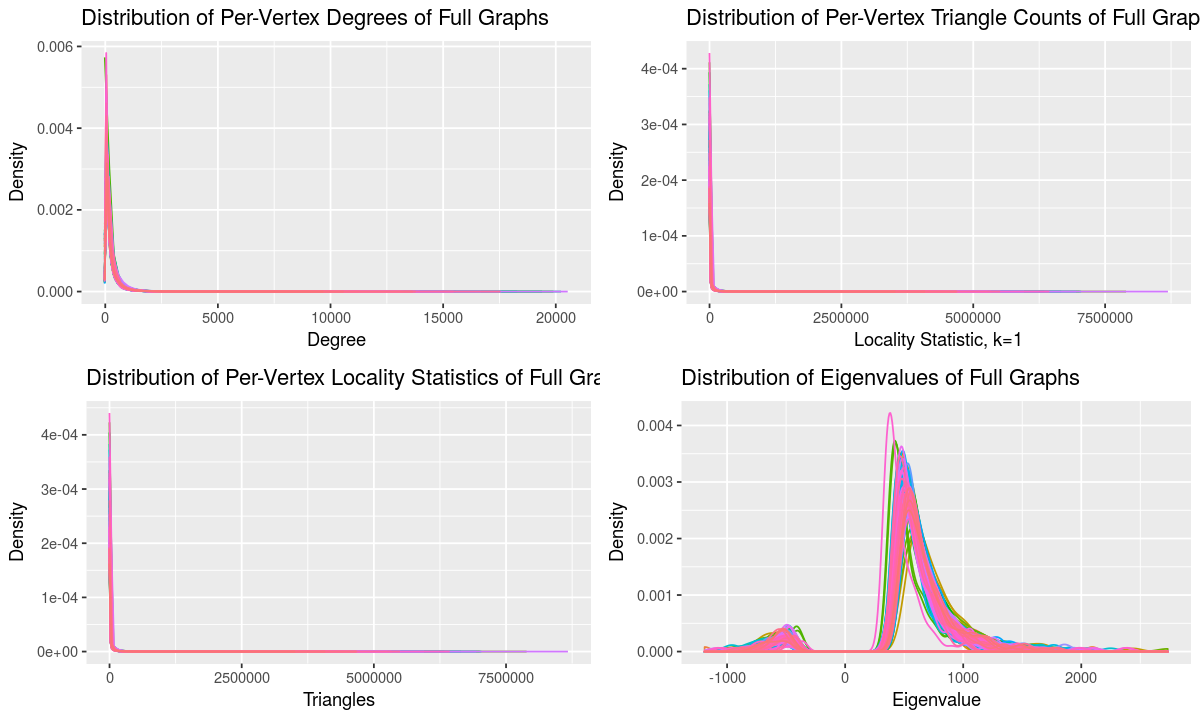

In [20]:
fx.degs.dat <- data.frame(id=c(), x=c(), y=c())
fx.tris.dat <- data.frame(id=c(), x=c(), y=c())
fx.locs.dat <- data.frame(id=c(), x=c(), y=c())
fx.eigs.dat <- data.frame(id=c(), eigs=c())

for (name in names(fx.degs.vals)) {
    subid <- name
    fx.degs.dat <- rbind(fx.degs.dat, data.frame(id=subid, x = fx.degs.vals[[subid]]$x, y=fx.degs.vals[[subid]]$y))
    fx.tris.dat <- rbind(fx.tris.dat, data.frame(id=subid, x = fx.tris.vals[[subid]]$x, y=fx.tris.vals[[subid]]$y))
    fx.locs.dat <- rbind(fx.locs.dat, data.frame(id=subid, x = fx.locs.vals[[subid]]$x, y=fx.locs.vals[[subid]]$y))
    # fx.bets.dat <- rbind(fx.bets.dat, data.frame(id=name, bets = fx.bets.vals[[name]]))
    fx.eigs.dat <- rbind(fx.eigs.dat, data.frame(id=subid, eigs=fx.eigs.vals[[subid]]))
}

require(ggplot2)
options(repr.plot.height=6, repr.plot.width=10)
degs <- ggplot(data = fx.degs.dat, aes(x=x, y=y, colour = id, group=id)) +
    geom_line() +
    xlab('Degree') +
    ylab('Density') +
    ggtitle('Distribution of Per-Vertex Degrees of Full Graphs') +
    theme(legend.position='none')

tris <- ggplot(data = fx.tris.dat, aes(x=x, y=y, colour = id, group=id)) +
    geom_line() +
    xlab('Triangles') +
    ylab('Density') +
    ggtitle('Distribution of Per-Vertex Locality Statistics of Full Graphs') +
    theme(legend.position='none')

locs <- ggplot(data = fx.locs.dat, aes(x=x, y=y, colour = id, group=id)) +
    geom_line() +
    xlab('Locality Statistic, k=1') +
    ylab('Density') +
    ggtitle('Distribution of Per-Vertex Triangle Counts of Full Graphs') +
    theme(legend.position='none')

eigs <- ggplot(data = fx.eigs.dat, aes(eigs, colour = id, group=id)) +
    geom_density() +
    xlab('Eigenvalue') +
    ylab('Density') +
    ggtitle('Distribution of Eigenvalues of Full Graphs') +
    theme(legend.position='none')


require(Rmisc)
file <- '../../img/ndmg_full/fx_analysis.png'
png(file)
fx.plots.analysis <- multiplot(degs, tris, locs, eigs, cols=2)
print(fx.plots.analysis)
dev.off()
fx.plots.analysis <- multiplot(degs, tris, locs, eigs, cols=2)
print(fx.plots.analysis)

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


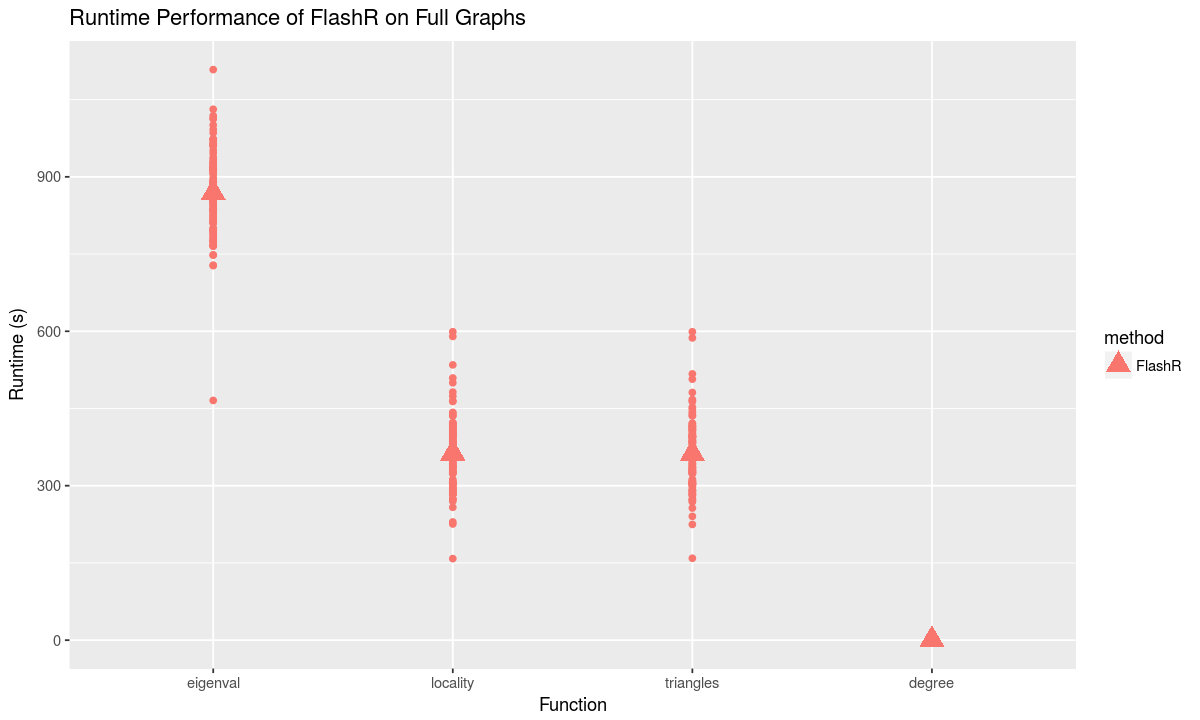

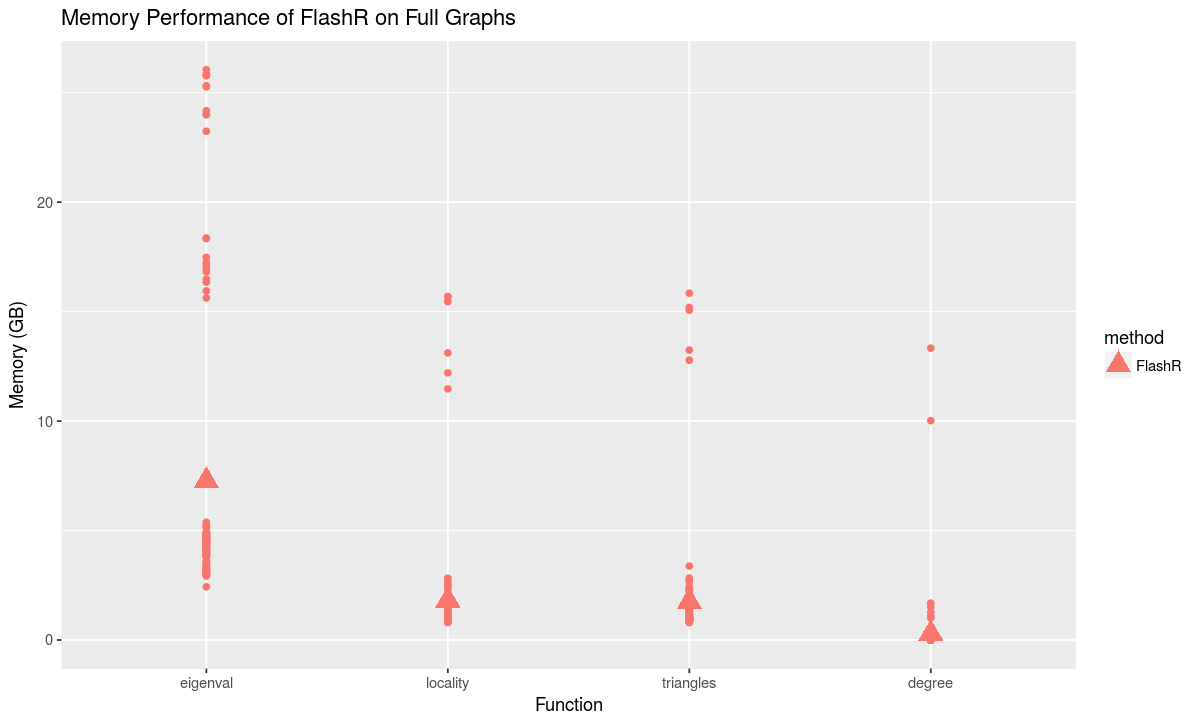

In [18]:
runtime <- data.frame(method="FlashR", func = "eigenval", time = unlist(fx.eigs.time))
runtime <- rbind(runtime, data.frame(method="FlashR", func = "locality", time = unlist(fx.locs.time)))
runtime <- rbind(runtime, data.frame(method="FlashR", func = "triangles", time = unlist(fx.tris.time)))
runtime <- rbind(runtime, data.frame(method="FlashR", func = "degree", time = unlist(fx.degs.time)))

memory <- data.frame(method="FlashR", func = "eigenval", time = unlist(fx.eigs.mem))
memory <- rbind(memory, data.frame(method="FlashR", func = "locality", time = unlist(fx.locs.mem)))
memory <- rbind(memory, data.frame(method="FlashR", func = "triangles", time = unlist(fx.tris.mem)))
memory <- rbind(memory, data.frame(method="FlashR", func = "degree", time = unlist(fx.degs.mem)))

file <- '../../img/ndmg_full/fx_runtime.png'
png(file)
fx.plots.runtime <- ggplot(runtime, aes(x=func, y=time, colour=method, group=method)) +
    geom_point() +
    stat_summary(fun.y = mean, geom = "point", shape=17, size=5) +
    xlab('Function') +
    ylab('Runtime (s)') +
    ggtitle('Runtime Performance of FlashR on Full Graphs')
print(fx.plots.runtime)
dev.off()
fx.plots.runtime <- ggplot(runtime, aes(x=func, y=time, colour=method, group=method)) +
    geom_point() +
    stat_summary(fun.y = mean, geom = "point", shape=17, size=5) +
    xlab('Function') +
    ylab('Runtime (s)') +
    ggtitle('Runtime Performance of FlashR on Full Graphs')
print(fx.plots.runtime)

file <- '../../img/ndmg_full/fx_memory.png'
png(file)
fx.plots.memory <- ggplot(memory, aes(x=func, y=time, colour=method, group=method)) +
    geom_point() +
    stat_summary(fun.y = mean, geom = "point", shape=17, size=5) +
    xlab('Function') +
    ylab('Memory (GB)') +
    ggtitle('Memory Performance of FlashR on Full Graphs')

print(fx.plots.memory)
dev.off()

fx.plots.memory <- ggplot(memory, aes(x=func, y=time, colour=method, group=method)) +
    geom_point() +
    stat_summary(fun.y = mean, geom = "point", shape=17, size=5) +
    xlab('Function') +
    ylab('Memory (GB)') +
    ggtitle('Memory Performance of FlashR on Full Graphs')
print(fx.plots.memory)

In [18]:
fx.degs.dat <- data.frame(id=c(), x=c(), y=c())
fx.tris.dat <- data.frame(id=c(), x=c(), y=c())
fx.locs.dat <- data.frame(id=c(), x=c(), y=c())
fx.eigs.dat <- data.frame(id=c(), eigs=c())

<0 x 0 matrix>

and next using igraph:

In [ ]:
ig_graphs <- sapply(elist_names, function(x) read_graph(x, format='ncol',
                                                        directed=FALSE),
    simplify=FALSE)

In [ ]:
ig.tris.vals <- list()
ig.bets.vals <- list()
ig.locs.vals <- lisgt()
ig.degs.vals <- list()
ig.eigs.vals <- list()

ig.tris.time <- list()
ig.bets.time <- list()
ig.locs.time <- list()
ig.degs.time <- list()
ig.eigs.time <- list()

ig.tris.mem <- list()
ig.bets.mem <- list()
ig.locs.mem <- list()
ig.degs.mem <- list()
ig.eigs.mem <- list()

for (name in names(ig_graphs)) {
    subid <- str_extract(string=name, pattern=perl('(?=sub-)(.*)(?=_ses)(.*)(?=_dwi)'))
    g <- ig_graphs[[name]]  # NOTE: igraph ignores isolated vertices by default
    
    res_degs <- analyze_performance(degree, list(g), path = '.')
    res_degs$kde <- density(as.vector(res_degs$out), n=100)
    ig.degs.vals[[subid]]$x <- res_degs$kde$x  # degrees x of each vertex
    ig.degs.vals[[subid]]$y <- res_degs$kde$y  # degrees dens of each vertex
    ig.degs.time[[subid]] <- res_degs$time
    ig.degs.mem[[subid]] <- res_degs$mem
    # fx.bets.vals[[name]] <- as.vector(fg.betweenness(g, vids=degnz))  this function doesn't work
    
    res_tris <- analyze_performance(ig.triangles, list(g))
    res_tris$kde <- density(as.vector(res_tris$out), n=100)
    ig.tris.vals[[subid]]$x <- res_tris$kde$x  # degrees x of each vertex
    ig.tris.vals[[subid]]$y <- res_tris$kde$y  # degrees dens of each vertex
    ig.tris.time[[subid]] <- res_tris$time
    ig.tris.mem[[subid]] <- res_tris$mem
    
    res_loc <- analyze_performance(local_scan, list(g, order=1))
    res_loc$kde <- density(as.vector(res_loc$out), n=100)
    ig.locs.vals[[subid]]$x <- res_loc$kde$x  # degrees x of each vertex
    ig.locs.vals[[subid]]$y <- res_loc$kde$y  # degrees dens of each vertex
    ig.locs.time[[subid]] <- res_loc$time
    ig.locs.mem[[subid]] <- res_loc$mem
    
    # ig.bets.vals[[name]] <- as.vector(betweenness(g))  # betweenness-centrality for non-isolated vertices

    res_eig <- analyze_performance(spectrum, list(g, which=list(pos="LM", howmany=100)))
    ig.eigs.vals[[subid]] <- res_eig$out$values
    ig.eigs.time[[subid]] <- res_eig$time
    ig.eigs.mem[[subid]] <- res_eig$mem
}

In [ ]:
ig.degs.dat <- data.frame(id=c(), locs=c())
ig.tris.dat <- data.frame(id=c(), tris=c())
ig.locs.dat <- data.frame(id=c(), locs=c())
ig.bets.dat <- data.frame(id=c(), bets=c())
ig.eigs.dat <- data.frame(id=c(), eigs=c())

hdist.dat <- data.frame(id=c(), method=c(), hd=c())

library(stringr)
if (any(names(fx.degs.vals) != names(ig.degs.vals))) {
    print('Names are not equal!')
}
for (name in names(fx.degs.vals)) {
    subid <- name
    ig.degs.dat <- rbind(ig.degs.dat, data.frame(id=subid, degs = ig.degs.vals[[subid]]))
    ig.tris.dat <- rbind(ig.tris.dat, data.frame(id=subid, tris = ig.tris.vals[[subid]]))
    ig.locs.dat <- rbind(ig.locs.dat, data.frame(id=subid, locs = ig.locs.vals[[subid]]))
    # ig.bets.dat <- rbind(ig.bets.dat, data.frame(id=name, bets = fx.bets.vals[[name]]))
    ig.eigs.dat <- rbind(ig.eigs.dat, data.frame(id=subid, eigs=ig.eigs.vals[[subid]]))
    
    diff.deg <- compare_distrs(ig.degs.vals[[subid]], ig.degs.vals[[subid]])
    hdist.dat <- rbind(hdist.dat, data.frame(id=subid, method="degree", hd=diff.deg$hd))
    
    diff.tri <- compare_distrs(ig.tris.vals[[subid]], ig.tris.vals[[subid]])
    hdist.dat <- rbind(hdist.dat, data.frame(id=subid, method="triangles", hd=diff.tri$hd))
    
    diff.locs <- compare_distrs(ig.locs.vals[[subid]], ig.locs.vals[[subid]])
    hdist.dat <- rbind(hdist.dat, data.frame(id=subid, method="locality", hd=diff.locs$hd))
    
    diff.eigs <- compare_distrs(ig.eigs.vals[[subid]], ig.eigs.vals[[subid]])
    hdist.dat <- rbind(hdist.dat, data.frame(id=subid, method="eigenval", hd=diff.eigs$hd))
}


# Igraph Results

And then the results using igraph for graph analysis:

In [ ]:
options(repr.plot.height=6, repr.plot.width=10)
degs <- ggplot(data = ig.degs.dat, aes(degs, colour = id)) +
    geom_density() +
    xlim(0, 200) +
    xlab('Degree') +
    ylab('Density')

tris <- ggplot(data = ig.tris.dat, aes(tris, colour = id)) +
    geom_density() +
    xlim(0, 200) +
    xlab('Triangles') +
    ylab('Density')

locs <- ggplot(data = ig.locs.dat, aes(locs, colour = id)) +
    geom_density() +
    xlim(0, 200) +
    xlab('Locality Statistic 1') +
    ylab('Density')

eigs <- ggplot(data = ig.eigs.dat, aes(eigs, colour = id)) +
    geom_density() +
    xlim(0, 200) +
    xlab('Eigenvalue') +
    ylab('Density')

multiplot(degs, tris, locs, eigs, cols=2)

# Performance Comparison

Finally, we compare runtime (in seconds) and peak memory usage (in GB) for FlashGraphR vs igraph for the statistics computed above, making sure that the statistics estimated are the same for both:

In [ ]:
options(repr.plot.height=4, repr.plot.width=6)

runtime <- data.frame(method="FlashR", func = "eigenval", time = unlist(fx.eigs.time))
runtime <- rbind(runtime, data.frame(method="FlashR", func = "locality", time = unlist(fx.locs.time)))
runtime <- rbind(runtime, data.frame(method="FlashR", func = "triangles", time = unlist(fx.tris.time)))
runtime <- rbind(runtime, data.frame(method="FlashR", func = "degree", time = unlist(fx.degs.time)))
runtime <- rbind(runtime, data.frame(method="igraph", func = "eigenval", time = unlist(ig.eigs.time)))
runtime <- rbind(runtime, data.frame(method="igraph", func = "locality", time = unlist(ig.locs.time)))
runtime <- rbind(runtime, data.frame(method="igraph", func = "triangles", time = unlist(ig.tris.time)))
runtime <- rbind(runtime, data.frame(method="igraph", func = "degree", time = unlist(ig.degs.time)))

memory <- data.frame(method="FlashR", func = "eigenval", time = unlist(fx.eigs.mem))
memory <- rbind(memory, data.frame(method="FlashR", func = "locality", time = unlist(fx.locs.mem)))
memory <- rbind(memory, data.frame(method="FlashR", func = "triangles", time = unlist(fx.tris.mem)))
memory <- rbind(memory, data.frame(method="FlashR", func = "degree", time = unlist(fx.degs.mem)))
memory <- rbind(memory, data.frame(method="igraph", func = "eigenval", time = unlist(ig.eigs.mem)))
memory <- rbind(memory, data.frame(method="igraph", func = "locality", time = unlist(ig.locs.mem)))
memory <- rbind(memory, data.frame(method="igraph", func = "triangles", time = unlist(ig.tris.mem)))
memory <- rbind(memory, data.frame(method="igraph", func = "degree", time = unlist(ig.degs.mem)))

ggplot(runtime, aes(x=func, y=time, colour=method, group=method)) +
    geom_point() +
    stat_summary(fun.y = mean, geom = "point", shape=17, size=3) +
    xlab('Function') +
    ylab('Runtime (s)') +
    ggtitle('Runtime Performance comparison of FlashGraphR and iGraph')

ggplot(memory, aes(x=func, y=time, colour=method, group=method)) +
    geom_point() +
    stat_summary(fun.y = mean, geom = "point", shape=17, size=5) +
    xlab('Function') +
    ylab('Memory (GB)') +
    ggtitle('Memory Performance comparison of FlashGraphR and iGraph')


ggplot(hdist.dat, aes(x=method, y=hd, colour=method)) +
    geom_point() +
    xlab('Function') +
    ylab('Hellinger Distance') +
    ggtitle('Hellinger Distance between FlashGraphR and iGraph statistics')